An automated multi Scale Retinex with Color Restoration for image enhancement (https://ieeexplore.ieee.org/document/6176791)

'color constancy' is a technique used for image enhancement 

A color constancy algorithm must be able to simultaneously achieve the 3 properties given below,

1. dynamic range compression,

2. color independence from the spectral distribution of the scene illuminant and,

3. color and lightness rendition.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
  
from sklearn.metrics import classification_report, confusion_matrix
  
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
  
import cv2

In [5]:
#create datagenerators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=90)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'images/training',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        'images/testing',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 126 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


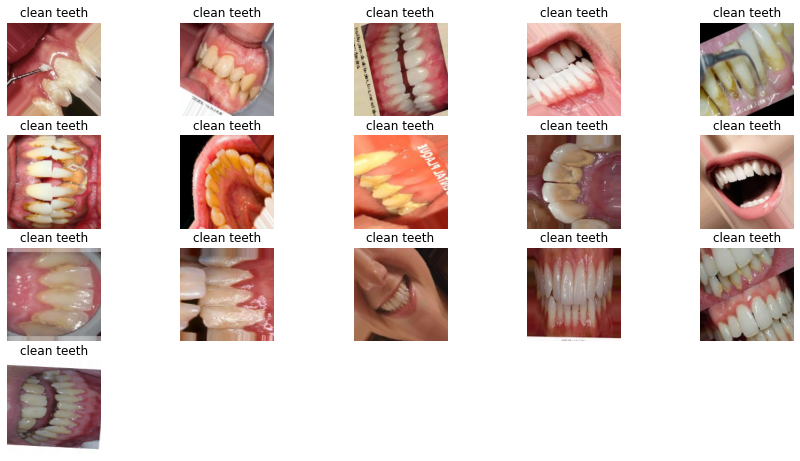

In [6]:
#plot one batch of images
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list
  
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(16):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
          
x,y = next(train_generator)
plot_images(x,y)

In [7]:

# InceptionResNetV2 base model
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(150,150,3)
                     )
  
base_model.trainable=False
  
model = tf.keras.Sequential([ 
        base_model,
        # tf.keras.layers.Dense(256, activation='relu'),  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        # tf.keras.layers.Dense(512, activation='relu'),
        # tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

In [8]:

model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 3, 3, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                        

In [9]:
history = model.fit(train_generator, epochs = 25, validation_data = validation_generator)

Epoch 1/25
8/8 [==============================] - 13s 625ms/step - loss: 1.5107 - accuracy: 0.6270 - val_loss: 0.4890 - val_accuracy: 0.9130
Epoch 2/25
8/8 [==============================] - 1s 122ms/step - loss: 1.0946 - accuracy: 0.7778 - val_loss: 1.3543 - val_accuracy: 0.5652
Epoch 3/25
8/8 [==============================] - 1s 130ms/step - loss: 1.0147 - accuracy: 0.7381 - val_loss: 0.3778 - val_accuracy: 0.8696
Epoch 4/25
8/8 [==============================] - 1s 137ms/step - loss: 0.4619 - accuracy: 0.8016 - val_loss: 0.4522 - val_accuracy: 0.6957
Epoch 5/25
8/8 [==============================] - 1s 124ms/step - loss: 0.5461 - accuracy: 0.7778 - val_loss: 0.3282 - val_accuracy: 0.8261
Epoch 6/25
8/8 [==============================] - 1s 127ms/step - loss: 0.4808 - accuracy: 0.7778 - val_loss: 0.2635 - val_accuracy: 0.9130
Epoch 7/25
8/8 [==============================] - 1s 124ms/step - loss: 0.4040 - accuracy: 0.8492 - val_loss: 0.3962 - val_accuracy: 0.7391
Epoch 8/25
8/8 [===

In [10]:
model.save('plaque_prediction')

INFO:tensorflow:Assets written to: plaque_prediction\assets


In [2]:
import keras
model = keras.models.load_model('plaque_prediction')

C:\Users\svobbilis2\Anaconda3\envs\cityhack22\lib\site-packages\keras\layers\core\lambda_layer.py:297: UserWarning: keras.applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [97]:
#test on new image
test_img_path = "plaque_test.jpg"
classes = ['Clean Teeth', 'Plaque Detected'] 
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (150, 150)).reshape(-1, 150, 150, 3)/255
prediction = model.predict(resized_img)
prediction_value = np.argmax(prediction)
classes[prediction_value]

'Plaque Detected'

In [98]:
#test on new image
test_img_path = "clean teeth test.jpg"
classes = ['Clean Teeth', 'Plaque Detected']  
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (150, 150)).reshape(-1, 150, 150, 3)/255
prediction = model.predict(resized_img)
prediction_value = np.argmax(prediction)
classes[prediction_value]

'Clean Teeth'